In [1]:
import os
from astropy.io import fits
import sunpy.map
#from sunpy.coordinates import NorthOffsetFrame
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
import matplotlib.colors
import glob
from scipy import ndimage
import numpy as np
#import sunpy.timeseries
import scipy.ndimage as ndimage
from scipy.ndimage import label
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import ast  
import seaborn as sns

/home/vindia/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import pandas as pd

In [40]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[5], "r") as f:
    print(txt_files[5])
    data = [ast.literal_eval(line.strip()) for line in f]
df=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,325,24.598329,26.002419,23.311326,325.0,-2.5,1,6.534228e+22,3.752820e+20,3.475653e+18,1
1,237,27.362044,29.268403,25.535887,235.0,17.5,2,1.889910e+22,2.037068e+20,1.055816e+18,1
2,238,27.362044,29.268403,25.535887,235.0,27.5,2,1.689000e+22,2.037068e+20,1.017470e+18,1
3,185,35.551683,36.262354,34.530530,185.0,-2.5,3,1.176134e+23,6.027202e+20,6.256033e+18,1
4,195,34.451709,35.623047,33.026710,195.0,-2.5,3,2.126515e+22,2.210609e+20,1.131125e+18,1


In [52]:
df.shape

(360, 11)

In [42]:
df.sample(5)

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
289,289,21.669585,21.915095,21.581521,285.0,37.5,7,6.362568e+20,2.435538e+19,4.241712e+16,0
306,306,22.389433,23.288555,21.738449,305.0,7.5,7,6.871782e+20,2.032703e+19,3.674750e+16,0
42,23,21.302126,23.034456,19.948221,25.0,-22.5,7,2.654086e+22,6.271300e+20,1.534154e+18,0
74,55,19.456947,20.009105,19.251056,55.0,-2.5,7,2.332941e+22,1.589254e+20,1.240926e+18,0
211,204,32.963414,34.503970,31.242387,205.0,-12.5,7,4.251484e+23,9.461384e+20,2.310589e+19,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patchid      360 non-null    int64  
 1   meantd       360 non-null    float64
 2   maxtd        360 non-null    float64
 3   mintd        360 non-null    float64
 4   lamda        360 non-null    float64
 5   phi          360 non-null    float64
 6   day          360 non-null    int64  
 7   TFlux        360 non-null    float64
 8   maxTotflux   360 non-null    float64
 9   meanTotflux  360 non-null    float64
 10  flags        360 non-null    int64  
dtypes: float64(8), int64(3)
memory usage: 31.1 KB


In [44]:
df.isnull().sum()     #missing value check

patchid        0
meantd         0
maxtd          0
mintd          0
lamda          0
phi            0
day            0
TFlux          0
maxTotflux     0
meanTotflux    0
flags          0
dtype: int64

In [45]:
df.describe()

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
count,360.000000,360.000000,360.000000,360.000000,360.00000,360.000000,360.000000,3.600000e+02,3.600000e+02,3.600000e+02,360.000000
mean,180.500000,26.787617,28.118717,25.522565,180.00000,2.500000,6.819444,1.039962e+24,1.003847e+21,5.720059e+19,0.058333
std,104.067286,5.351683,5.337332,5.211506,104.02753,28.762789,0.809525,4.195372e+24,2.455701e+21,2.299474e+20,0.234699
min,1.000000,19.425846,19.929215,19.251056,5.00000,-42.500000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,90.750000,22.291817,23.225030,21.581521,92.50000,-22.500000,7.000000,3.494023e+20,1.718248e+19,2.197570e+16,0.000000
50%,180.500000,25.508611,27.414881,23.634630,180.00000,2.500000,7.000000,3.500573e+21,6.753028e+19,2.019911e+17,0.000000
75%,270.250000,31.282033,33.100175,29.348693,267.50000,27.500000,7.000000,1.028579e+23,4.303825e+20,5.764573e+18,0.000000
max,360.000000,36.271013,36.392868,35.913117,355.00000,47.500000,7.000000,3.572550e+25,1.183623e+22,1.910454e+21,1.000000


In [9]:
df.duplicated().sum()

0

In [46]:
df.corr()

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,1.214891e-01,8.959259e-02,1.481588e-01,9.996180e-01,2.763865e-02,-0.086116,0.028593,-0.011552,0.029336,0.015111
meantd,0.121489,1.000000e+00,9.929812e-01,9.928759e-01,1.215355e-01,-4.346013e-17,-0.065212,-0.011987,-0.025420,-0.009839,0.092407
maxtd,0.089593,9.929812e-01,1.000000e+00,9.718639e-01,8.962683e-02,-2.681661e-17,-0.051133,-0.000348,-0.017725,0.001773,0.076416
mintd,0.148159,9.928759e-01,9.718639e-01,1.000000e+00,1.482154e-01,2.508737e-17,-0.078936,-0.021741,-0.030386,-0.019595,0.108277
lamda,0.999618,1.215355e-01,8.962683e-02,1.482154e-01,1.000000e+00,-1.947396e-17,-0.085173,0.030766,-0.008941,0.031564,0.014261
phi,0.027639,-4.346013e-17,-2.681661e-17,2.508737e-17,-1.947396e-17,1.000000e+00,-0.035291,-0.078191,-0.094625,-0.080168,0.030947
day,-0.086116,-6.521188e-02,-5.113342e-02,-7.893575e-02,-8.517342e-02,-3.529118e-02,1.000000,0.000927,-0.101477,-0.000174,-0.897376
TFlux,0.028593,-1.198701e-02,-3.479147e-04,-2.174108e-02,3.076596e-02,-7.819095e-02,0.000927,1.000000,0.817348,0.999498,0.015199
maxTotflux,-0.011552,-2.542025e-02,-1.772489e-02,-3.038594e-02,-8.940520e-03,-9.462458e-02,-0.101477,0.817348,1.000000,0.818855,0.130162
meanTotflux,0.029336,-9.838912e-03,1.773041e-03,-1.959476e-02,3.156396e-02,-8.016799e-02,-0.000174,0.999498,0.818855,1.000000,0.016871


In [51]:
df["flags"].value_counts()

0    339
1     21
Name: flags, dtype: int64

<AxesSubplot:>

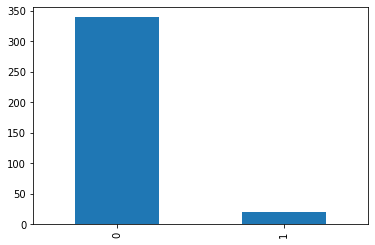

In [47]:
df["flags"].value_counts().plot(kind="bar")

<AxesSubplot:ylabel='flags'>

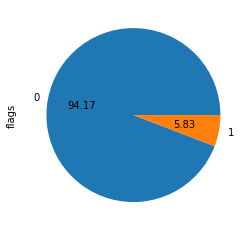

In [48]:
df["flags"].value_counts().plot(kind="pie", autopct="%.2f")

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

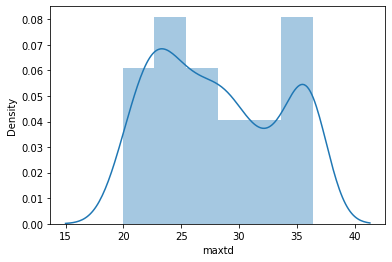

In [49]:
sns.distplot(df["maxtd"])

<AxesSubplot:>

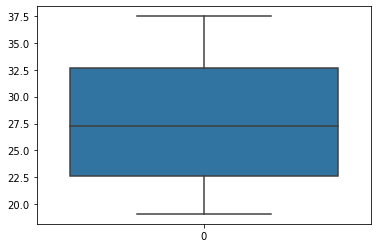

In [21]:
sns.boxplot(df["tipdiff"])

In [24]:
df["tipdiff"].skew()

0.08652474540483304

<AxesSubplot:xlabel='lamda', ylabel='tipdiff'>

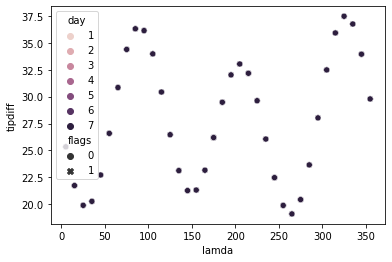

In [35]:
sns.scatterplot(data=df, x='lamda',y='tipdiff',hue='day',style="flags")

<AxesSubplot:xlabel='phi', ylabel='maxtd'>

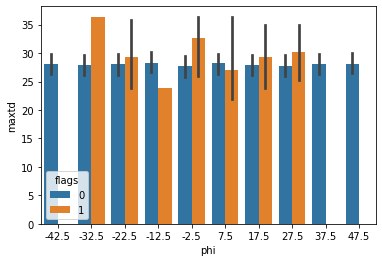

In [50]:
sns.barplot(data=df, x='phi',y='maxtd',hue='flags')

In [107]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[2], "r") as f:
    print(txt_files[2])
    data = [ast.literal_eval(line.strip()) for line in f]
df0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,564,23.966036,25.495680,22.596793,285.0,-12.5,1,2.169728e+23,6.457557e+20,1.179200e+19,1
1,565,23.966036,25.495680,22.596793,285.0,-2.5,1,1.667119e+23,6.457557e+20,8.867655e+18,1
2,575,25.536088,27.224212,23.939379,290.0,-2.5,1,1.928484e+23,6.457557e+20,1.025789e+19,1
3,625,33.171895,33.977458,32.113608,315.0,-2.5,1,1.468510e+23,5.092293e+20,7.811226e+18,1
4,635,33.908413,34.282423,33.246726,320.0,-2.5,1,1.444461e+23,5.092293e+20,7.683302e+18,1


In [108]:
df0.corr()

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,1.992192e-01,1.904745e-01,2.028653e-01,9.999045e-01,1.381928e-02,-0.118440,-0.051166,-0.087763,-0.048946,0.116156
meantd,0.199219,1.000000e+00,9.937242e-01,9.938167e-01,1.992383e-01,-6.223308e-17,0.091502,-0.044889,-0.077765,-0.041231,-0.062347
maxtd,0.190474,9.937242e-01,1.000000e+00,9.752081e-01,1.904927e-01,-5.956100e-17,0.093537,-0.055743,-0.088334,-0.052105,-0.066754
mintd,0.202865,9.938167e-01,9.752081e-01,1.000000e+00,2.028847e-01,-1.054665e-17,0.088720,-0.034395,-0.067079,-0.030775,-0.057451
lamda,0.999905,1.992383e-01,1.904927e-01,2.028847e-01,1.000000e+00,-3.470440e-17,-0.119180,-0.049741,-0.085772,-0.047500,0.117068
phi,0.013819,-6.223308e-17,-5.956100e-17,-1.054665e-17,-3.470440e-17,1.000000e+00,0.052774,-0.103475,-0.144657,-0.104945,-0.065158
day,-0.118440,9.150230e-02,9.353697e-02,8.871975e-02,-1.191802e-01,5.277360e-02,1.000000,-0.037313,-0.111409,-0.036487,-0.829071
TFlux,-0.051166,-4.488851e-02,-5.574268e-02,-3.439510e-02,-4.974071e-02,-1.034747e-01,-0.037313,1.000000,0.783435,0.999559,0.015381
maxTotflux,-0.087763,-7.776501e-02,-8.833360e-02,-6.707934e-02,-8.577173e-02,-1.446575e-01,-0.111409,0.783435,1.000000,0.781588,0.123385
meanTotflux,-0.048946,-4.123103e-02,-5.210495e-02,-3.077475e-02,-4.750012e-02,-1.049455e-01,-0.036487,0.999559,0.781588,1.000000,0.014668


In [109]:
df0.corr(method='pearson')

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,1.992192e-01,1.904745e-01,2.028653e-01,9.999045e-01,1.381928e-02,-0.118440,-0.051166,-0.087763,-0.048946,0.116156
meantd,0.199219,1.000000e+00,9.937242e-01,9.938167e-01,1.992383e-01,-6.223308e-17,0.091502,-0.044889,-0.077765,-0.041231,-0.062347
maxtd,0.190474,9.937242e-01,1.000000e+00,9.752081e-01,1.904927e-01,-5.956100e-17,0.093537,-0.055743,-0.088334,-0.052105,-0.066754
mintd,0.202865,9.938167e-01,9.752081e-01,1.000000e+00,2.028847e-01,-1.054665e-17,0.088720,-0.034395,-0.067079,-0.030775,-0.057451
lamda,0.999905,1.992383e-01,1.904927e-01,2.028847e-01,1.000000e+00,-3.470440e-17,-0.119180,-0.049741,-0.085772,-0.047500,0.117068
phi,0.013819,-6.223308e-17,-5.956100e-17,-1.054665e-17,-3.470440e-17,1.000000e+00,0.052774,-0.103475,-0.144657,-0.104945,-0.065158
day,-0.118440,9.150230e-02,9.353697e-02,8.871975e-02,-1.191802e-01,5.277360e-02,1.000000,-0.037313,-0.111409,-0.036487,-0.829071
TFlux,-0.051166,-4.488851e-02,-5.574268e-02,-3.439510e-02,-4.974071e-02,-1.034747e-01,-0.037313,1.000000,0.783435,0.999559,0.015381
maxTotflux,-0.087763,-7.776501e-02,-8.833360e-02,-6.707934e-02,-8.577173e-02,-1.446575e-01,-0.111409,0.783435,1.000000,0.781588,0.123385
meanTotflux,-0.048946,-4.123103e-02,-5.210495e-02,-3.077475e-02,-4.750012e-02,-1.049455e-01,-0.036487,0.999559,0.781588,1.000000,0.014668


In [110]:
df0.corr(method='kendall')

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,0.134518,0.117870,0.150965,0.993722,0.013185,-0.095576,-0.034235,-0.028249,-0.031901,0.094907
meantd,0.134518,1.000000,0.963398,0.959280,0.135368,0.000000,0.083286,-0.023650,-0.020331,-0.025633,-0.048912
maxtd,0.117870,0.963398,1.000000,0.922625,0.118614,0.000000,0.087957,-0.022665,-0.020226,-0.024820,-0.053434
mintd,0.150965,0.959280,0.922625,1.000000,0.151919,0.000000,0.081798,-0.023976,-0.019805,-0.025603,-0.048100
lamda,0.993722,0.135368,0.118614,0.151919,1.000000,0.000000,-0.096731,-0.031442,-0.025726,-0.029070,0.096247
phi,0.013185,0.000000,0.000000,0.000000,0.000000,1.000000,0.046491,-0.208430,-0.198696,-0.208967,-0.055798
day,-0.095576,0.083286,0.087957,0.081798,-0.096731,0.046491,1.000000,-0.150401,-0.192749,-0.148463,-0.921502
TFlux,-0.034235,-0.023650,-0.022665,-0.023976,-0.031442,-0.208430,-0.150401,1.000000,0.893203,0.982552,0.156158
maxTotflux,-0.028249,-0.020331,-0.020226,-0.019805,-0.025726,-0.198696,-0.192749,0.893203,1.000000,0.893063,0.207856
meanTotflux,-0.031901,-0.025633,-0.024820,-0.025603,-0.029070,-0.208967,-0.148463,0.982552,0.893063,1.000000,0.154494


In [111]:
df0.corr("spearman")

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,0.202727,0.173841,0.230611,0.999905,0.013819,-0.116264,-0.056033,-0.046944,-0.053041,0.116156
meantd,0.202727,1.000000,0.996326,0.996270,0.202746,0.000000,0.102406,-0.035234,-0.032264,-0.038335,-0.059493
maxtd,0.173841,0.996326,1.000000,0.988061,0.173858,0.000000,0.108118,-0.034026,-0.032355,-0.037229,-0.064957
mintd,0.230611,0.996270,0.988061,1.000000,0.230633,0.000000,0.100707,-0.035754,-0.031727,-0.038600,-0.058462
lamda,0.999905,0.202746,0.173858,0.230633,1.000000,0.000000,-0.117032,-0.051853,-0.043016,-0.048826,0.117068
phi,0.013819,0.000000,0.000000,0.000000,0.000000,1.000000,0.054768,-0.302854,-0.284565,-0.305371,-0.065158
day,-0.116264,0.102406,0.108118,0.100707,-0.117032,0.054768,1.000000,-0.185587,-0.238398,-0.183215,-0.929947
TFlux,-0.056033,-0.035234,-0.034026,-0.035754,-0.051853,-0.302854,-0.185587,1.000000,0.980871,0.999230,0.191114
maxTotflux,-0.046944,-0.032264,-0.032355,-0.031727,-0.043016,-0.284565,-0.238398,0.980871,1.000000,0.981165,0.254087
meanTotflux,-0.053041,-0.038335,-0.037229,-0.038600,-0.048826,-0.305371,-0.183215,0.999230,0.981165,1.000000,0.189077


<AxesSubplot:xlabel='maxtd', ylabel='Count'>

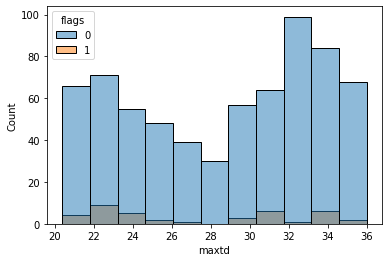

In [112]:
sns.histplot(data=df0, x="maxtd", hue="flags")

In [77]:
df0.shape

(720, 11)

In [78]:
df0["flags"].value_counts()


0    681
1     39
Name: flags, dtype: int64

<AxesSubplot:>

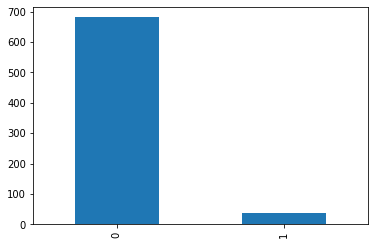

In [79]:
df0["flags"].value_counts().plot(kind="bar")

<AxesSubplot:ylabel='flags'>

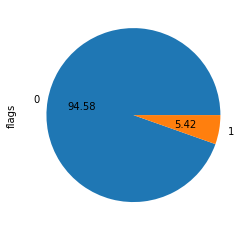

In [80]:
df0["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [119]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)


['/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(360).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(4320).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR1.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR3.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR4.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR5.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6(720).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6.txt']


In [81]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
df=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(360).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,284,23.966036,25.495680,22.596793,285.0,-12.5,1,2.169728e+23,6.457557e+20,1.179200e+19,1
1,285,23.966036,25.495680,22.596793,285.0,-2.5,1,1.667119e+23,6.457557e+20,8.867655e+18,1
2,315,33.171895,33.977458,32.113608,315.0,-2.5,1,1.468510e+23,5.092293e+20,7.811226e+18,1
3,156,21.560551,22.151330,21.246170,155.0,7.5,2,2.899707e+22,1.787286e+21,1.550645e+18,1
4,276,21.649647,22.573112,20.986042,275.0,7.5,2,1.329166e+25,8.538824e+21,7.107838e+20,1


In [82]:
df.shape

(360, 11)

In [83]:
df["flags"].value_counts()

0    342
1     18
Name: flags, dtype: int64

<AxesSubplot:>

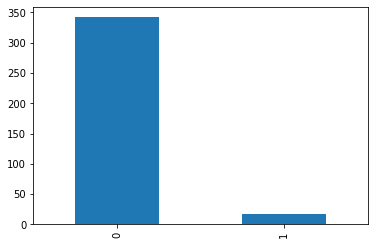

In [84]:
df["flags"].value_counts().plot(kind="bar")

<AxesSubplot:ylabel='flags'>

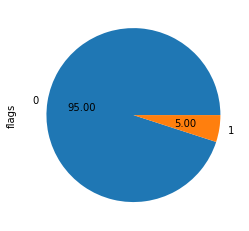

In [85]:
df["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [113]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[1], "r") as f:
    print(txt_files[1])
    data = [ast.literal_eval(line.strip()) for line in f]
df=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(3600).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,74,22.849129,23.595892,22.148373,8.5,20.0,1,1.165895e+22,1.645506e+21,1.976094e+18,1
1,90,22.282893,22.971383,21.646611,10.5,0.0,1,3.659663e+21,3.591975e+20,5.855461e+17,1
2,110,21.769824,22.392358,21.205156,12.5,0.0,1,8.703251e+21,3.591975e+20,1.392520e+18,1
3,130,21.315682,21.865265,20.829020,14.5,0.0,1,8.104269e+21,3.591975e+20,1.296683e+18,1
4,190,20.354876,20.651585,20.132103,20.5,0.0,1,1.339399e+21,2.097400e+20,2.143038e+17,1


<AxesSubplot:xlabel='maxtd', ylabel='Count'>

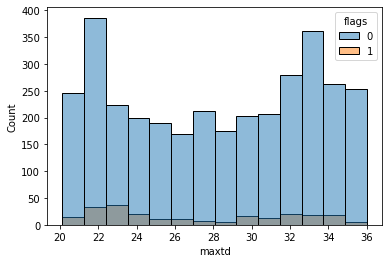

In [114]:
sns.histplot(data=df, x="maxtd", hue="flags")

<AxesSubplot:xlabel='flags', ylabel='maxtd'>

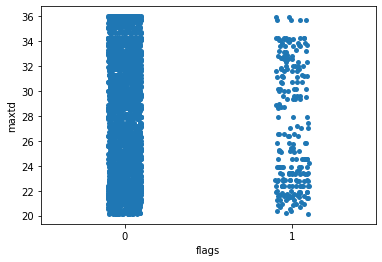

In [116]:
sns.stripplot(x="flags", y="maxtd", data=df)

In [117]:
maxtd_flag1 = df[df["flags"] == 1]["maxtd"]
maxtd_flag0 = df[df["flags"] == 0]["maxtd"]

In [101]:
df.shape


(3600, 11)

In [102]:
df["flags"].value_counts()

0    3368
1     232
Name: flags, dtype: int64

<AxesSubplot:ylabel='flags'>

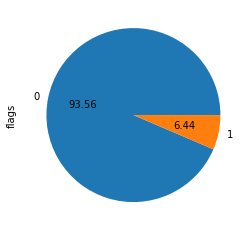

In [103]:
df["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [105]:
df.corr()

,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
patchid,1.000000,2.011391e-01,1.977019e-01,2.032812e-01,9.999846e-01,5.548607e-03,-0.083243,-0.033995,-0.038136,-0.033102,0.105861
meantd,0.201139,1.000000e+00,9.984590e-01,9.984598e-01,2.011422e-01,9.759827e-17,0.064569,-0.045810,-0.066344,-0.043784,-0.059692
maxtd,0.197702,9.984590e-01,1.000000e+00,9.938442e-01,1.977049e-01,2.055814e-16,0.064585,-0.049147,-0.070502,-0.047143,-0.060449
mintd,0.203281,9.984598e-01,9.938442e-01,1.000000e+00,2.032843e-01,7.379010e-17,0.064398,-0.042463,-0.062122,-0.040424,-0.058851
lamda,0.999985,2.011422e-01,1.977049e-01,2.032843e-01,1.000000e+00,4.637558e-17,-0.083475,-0.033627,-0.037652,-0.032728,0.106138
phi,0.005549,9.759827e-17,2.055814e-16,7.379010e-17,4.637558e-17,1.000000e+00,0.041578,-0.066430,-0.087383,-0.067442,-0.049636
day,-0.083243,6.456928e-02,6.458486e-02,6.439812e-02,-8.347457e-02,4.157823e-02,1.000000,-0.082191,-0.195680,-0.081374,-0.877352
TFlux,-0.033995,-4.580991e-02,-4.914731e-02,-4.246318e-02,-3.362712e-02,-6.643040e-02,-0.082191,1.000000,0.780284,0.999756,0.126657
maxTotflux,-0.038136,-6.634358e-02,-7.050205e-02,-6.212211e-02,-3.765218e-02,-8.738269e-02,-0.195680,0.780284,1.000000,0.780038,0.264784
meanTotflux,-0.033102,-4.378409e-02,-4.714279e-02,-4.042428e-02,-3.272799e-02,-6.744243e-02,-0.081374,0.999756,0.780038,1.000000,0.126222


In [120]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[2], "r") as f:
    print(txt_files[2])
    data = [ast.literal_eval(line.strip()) for line in f]
df=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR0(4320).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,88,22.849129,23.595892,22.148373,8.5,20.0,1,1.165895e+22,1.645506e+21,1.976094e+18,1
1,108,22.282893,22.971383,21.646611,10.5,0.0,1,3.659663e+21,3.591975e+20,5.855461e+17,1
2,132,21.769824,22.392358,21.205156,12.5,0.0,1,8.703251e+21,3.591975e+20,1.392520e+18,1
3,156,21.315682,21.865265,20.829020,14.5,0.0,1,8.104269e+21,3.591975e+20,1.296683e+18,1
4,228,20.354876,20.651585,20.132103,20.5,0.0,1,1.339399e+21,2.097400e+20,2.143038e+17,1


In [121]:
df.shape

(4320, 11)

<AxesSubplot:ylabel='flags'>

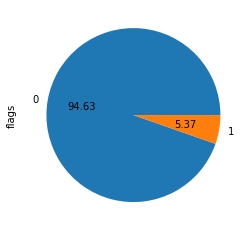

In [122]:
df["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [88]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[6], "r") as f:
    print(txt_files[6])
    data = [ast.literal_eval(line.strip()) for line in f]
df5=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df5.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6(720).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,192,34.451709,35.623047,33.026710,100.0,-32.5,1,2.411142e+21,4.947634e+20,1.526039e+17,1
1,197,34.451709,35.623047,33.026710,100.0,17.5,1,4.491611e+22,1.791793e+21,2.509280e+18,1
2,435,27.690267,29.268747,25.977279,220.0,-2.5,1,3.299734e+23,4.083579e+21,1.755177e+19,1
3,595,37.519081,39.950032,34.860143,300.0,-2.5,1,1.014058e+22,4.258954e+20,5.393924e+17,1
4,612,41.770648,43.156028,39.993399,310.0,-32.5,1,1.091839e+22,4.200894e+20,6.910376e+17,1


In [89]:
df5.shape


(720, 11)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

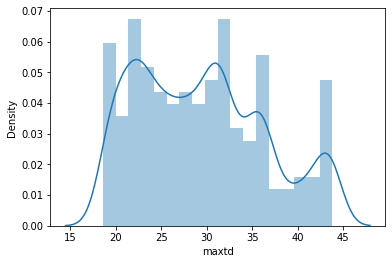

In [140]:
sns.distplot(df5["maxtd"])

In [90]:
df5["flags"].value_counts()

0    671
1     49
Name: flags, dtype: int64

<AxesSubplot:ylabel='flags'>

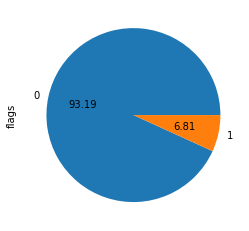

In [91]:
df5["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [ ]:
df.corr()

In [95]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
with open(txt_files[6], "r") as f:
    print(txt_files[6])
    data = [ast.literal_eval(line.strip()) for line in f]
df6=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df6.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/TF3CR/CR6(3600).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,154,20.785147,21.513406,20.152446,16.5,20.0,1,1.734711e+22,2.373632e+20,2.940188e+18,1
1,155,20.785147,21.513406,20.152446,16.5,25.0,1,1.437431e+22,2.373632e+20,2.544126e+18,1
2,823,36.319787,36.392868,36.160475,84.5,-35.0,1,7.346699e+20,2.563551e+20,1.426543e+17,1
3,1184,27.157028,28.093048,26.242644,120.5,-30.0,1,1.827813e+21,2.378926e+20,3.384839e+17,1
4,1470,21.661706,21.814014,21.581604,148.5,0.0,1,5.074537e+21,2.048819e+21,8.119259e+17,1


In [96]:
df6.shape

(3600, 11)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

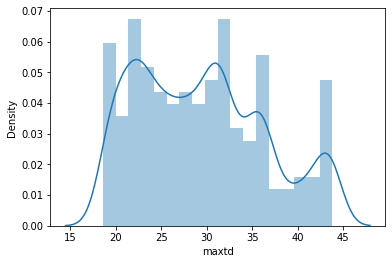

In [141]:
sns.distplot(df6["maxtd"])

In [97]:
df6["flags"].value_counts()

0    3329
1     271
Name: flags, dtype: int64

<AxesSubplot:ylabel='flags'>

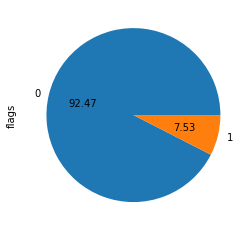

In [98]:
df6["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [123]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(360).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(4320).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR1.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR3.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR4.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR5.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6(720).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6.txt']


In [133]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
df0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(360).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,284,23.966036,25.495680,22.596793,285.0,-12.5,1,2.169728e+23,6.457557e+20,1.179200e+19,1
1,285,23.966036,25.495680,22.596793,285.0,-2.5,1,1.667119e+23,6.457557e+20,8.867655e+18,1
2,315,33.171895,33.977458,32.113608,315.0,-2.5,1,1.468510e+23,5.092293e+20,7.811226e+18,1
3,156,21.560551,22.151330,21.246170,155.0,7.5,2,2.899707e+22,1.787286e+21,1.550645e+18,1
4,276,21.649647,22.573112,20.986042,275.0,7.5,2,1.329166e+25,8.538824e+21,7.107838e+20,1


In [134]:
df0.shape

(360, 11)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

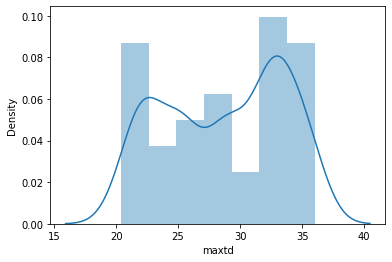

In [142]:
sns.distplot(df0["maxtd"])

In [135]:
df0["flags"].value_counts()

0    342
1     18
Name: flags, dtype: int64

<AxesSubplot:ylabel='flags'>

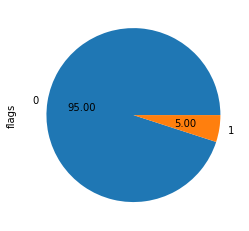

In [136]:
df0["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [130]:
with open(txt_files[1], "r") as f:
    print(txt_files[1])
    data = [ast.literal_eval(line.strip()) for line in f]
df1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df1.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(3600).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,74,22.849129,23.595892,22.148373,8.5,20.0,1,1.165895e+22,1.645506e+21,1.976094e+18,1
1,90,22.282893,22.971383,21.646611,10.5,0.0,1,3.659663e+21,3.591975e+20,5.855461e+17,1
2,110,21.769824,22.392358,21.205156,12.5,0.0,1,8.703251e+21,3.591975e+20,1.392520e+18,1
3,130,21.315682,21.865265,20.829020,14.5,0.0,1,8.104269e+21,3.591975e+20,1.296683e+18,1
4,190,20.354876,20.651585,20.132103,20.5,0.0,1,1.339399e+21,2.097400e+20,2.143038e+17,1


In [131]:
df1["flags"].value_counts()

0    3368
1     232
Name: flags, dtype: int64

<AxesSubplot:ylabel='flags'>

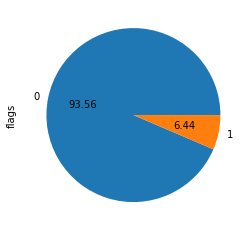

In [132]:
df1["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [137]:
with open(txt_files[2], "r") as f:
    print(txt_files[2])
    data = [ast.literal_eval(line.strip()) for line in f]
df2=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
df2.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(4320).txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,88,22.849129,23.595892,22.148373,8.5,20.0,1,1.165895e+22,1.645506e+21,1.976094e+18,1
1,108,22.282893,22.971383,21.646611,10.5,0.0,1,3.659663e+21,3.591975e+20,5.855461e+17,1
2,132,21.769824,22.392358,21.205156,12.5,0.0,1,8.703251e+21,3.591975e+20,1.392520e+18,1
3,156,21.315682,21.865265,20.829020,14.5,0.0,1,8.104269e+21,3.591975e+20,1.296683e+18,1
4,228,20.354876,20.651585,20.132103,20.5,0.0,1,1.339399e+21,2.097400e+20,2.143038e+17,1


In [138]:
df2["flags"].value_counts()

0    4088
1     232
Name: flags, dtype: int64

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

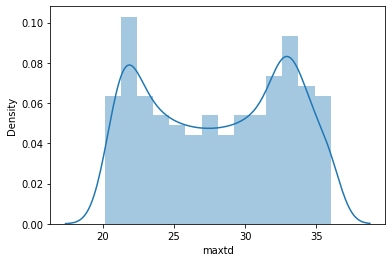

In [143]:
sns.distplot(df2["maxtd"])

<AxesSubplot:ylabel='flags'>

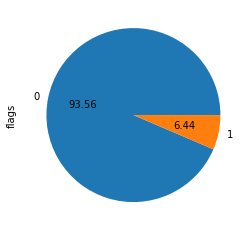

In [139]:
df1["flags"].value_counts().plot(kind="pie", autopct="%.2f")

In [151]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/RFT2e20/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)


['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(360).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0(4320).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR0.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR1(3240).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR1.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR3.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR4.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR5.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6(3600).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6(720).txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR6.txt']


In [147]:
with open(txt_files[4], "r") as f:
    print(txt_files[4])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR1.head()


/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR1.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,135,19.672662,20.354480,19.072618,16.5,0.0,1,5.292832e+21,2.456765e+20,8.468532e+17,1
1,245,18.172471,18.266428,18.139737,28.5,10.0,1,2.542862e+23,2.543473e+21,4.101391e+19,1
2,263,18.258754,18.471347,18.140981,30.5,10.0,1,4.871460e+22,2.543473e+21,7.857194e+18,1
3,266,18.258754,18.471347,18.140981,30.5,25.0,1,3.805993e+21,3.366880e+20,6.736272e+17,1
4,318,19.087709,19.636931,18.624367,36.5,15.0,1,2.140079e+22,3.153486e+20,3.537321e+18,1


In [148]:
dfCR1.shape

(3240, 11)

In [149]:
dfCR1["flags"].value_counts()

0    3026
1     214
Name: flags, dtype: int64

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

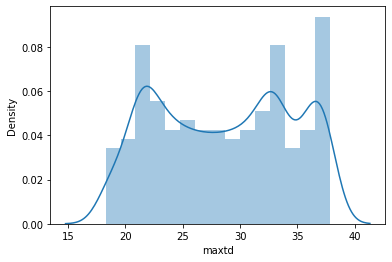

In [150]:
sns.distplot(dfCR1["maxtd"])

In [152]:
with open(txt_files[5], "r") as f:
    print(txt_files[5])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR1.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/TF3CR/CR1.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,30,25.001329,26.162794,23.868976,2.5,18.0,1,1.941340e+21,8.995575e+20,3.235567e+17,1
1,336,19.672662,20.354480,19.072618,16.5,0.0,1,5.292832e+21,2.456765e+20,8.468532e+17,1
2,611,18.172471,18.266428,18.139737,28.5,10.0,1,2.542862e+23,2.543473e+21,4.101391e+19,1
3,612,18.172471,18.266428,18.139737,28.5,12.0,1,2.138886e+23,1.327029e+21,3.477863e+19,1
4,656,18.258754,18.471347,18.140981,30.5,10.0,1,4.871460e+22,2.543473e+21,7.857194e+18,1


In [153]:
dfCR1.shape

(8100, 11)

In [154]:
dfCR1["flags"].value_counts()

0    7574
1     526
Name: flags, dtype: int64

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

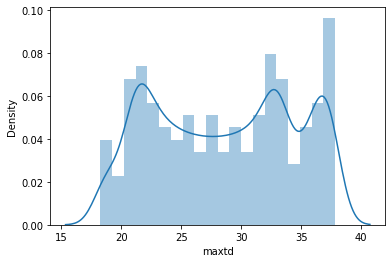

In [155]:
sns.distplot(dfCR1["maxtd"])

In [160]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/RFT2e21/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)


['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/RFT2e21/TF3CR/CR1.txt']


In [161]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR1.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/RFT2e21/TF3CR/CR1.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,210,29.138724,31.542193,26.711520,10.5,18.0,1,3.384295e+23,6.364877e+21,5.640491e+19,1
1,238,27.158848,29.589252,24.726489,12.5,-16.0,1,1.140602e+23,2.749336e+21,1.885293e+19,1
2,239,27.158848,29.589252,24.726489,12.5,-14.0,1,3.844582e+23,2.749336e+21,6.302593e+19,1
3,240,27.158848,29.589252,24.726489,12.5,-12.0,1,5.855906e+23,2.749336e+21,9.521798e+19,1
4,241,27.158848,29.589252,24.726489,12.5,-10.0,1,6.088263e+23,2.749336e+21,9.819778e+19,1


In [162]:
dfCR1.shape


(8100, 11)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

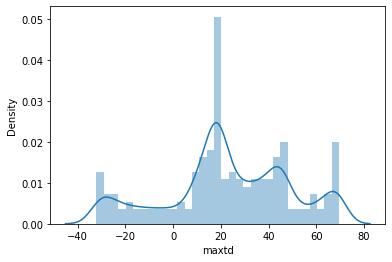

In [163]:
sns.distplot(dfCR1["maxtd"])

In [166]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR/CR1.txt']


In [167]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR1.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR/CR1.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,68,24.572970,25.971593,23.212247,4.5,4.0,1,1.584679e+22,3.453050e+20,2.535486e+18,1
1,113,23.467812,24.817842,22.165497,6.5,4.0,1,1.584679e+22,3.453050e+20,2.535486e+18,1
2,158,22.411246,23.700477,21.179058,8.5,4.0,1,1.089104e+22,3.453050e+20,1.742566e+18,1
3,159,22.411246,23.700477,21.179058,8.5,6.0,1,2.837008e+22,9.471929e+20,4.539212e+18,1
4,238,20.481297,21.614915,19.421542,12.5,-16.0,1,5.399815e+21,2.685765e+20,8.925314e+17,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

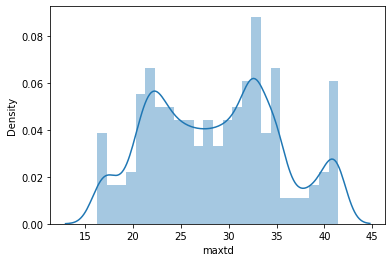

In [168]:
sns.distplot(dfCR1["maxtd"])


In [169]:
dfCR1.shape

(8100, 11)

# for -45 to 45_200_2e20

In [4]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR0.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR1.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR2.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR3.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR4.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR5.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR6.txt']


In [5]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_45/CR0.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,119,22.576931,23.565819,21.633590,6.5,16.0,1,4.998402e+22,7.687444e+20,8.261822e+18,1
1,165,21.812820,22.743870,20.934628,8.5,18.0,1,2.307747e+22,5.403471e+20,3.846244e+18,1
2,200,21.102541,21.966684,20.298032,10.5,-2.0,1,3.104838e+21,2.209781e+20,4.967741e+17,1
3,210,21.102541,21.966684,20.298032,10.5,18.0,1,3.528421e+22,5.403471e+20,5.880701e+18,1
4,245,20.452993,21.241835,19.729958,12.5,-2.0,1,1.542322e+22,2.209781e+20,2.467715e+18,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

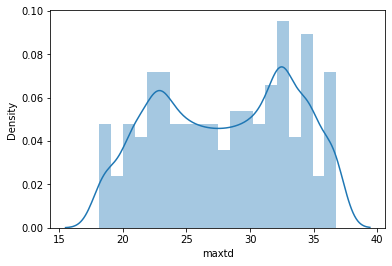

In [6]:
sns.distplot(dfCR0["maxtd"])

In [7]:
maxtd_flag1 = dfCR0[dfCR0["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR0[dfCR0["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

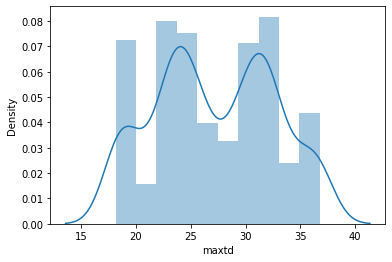

In [8]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

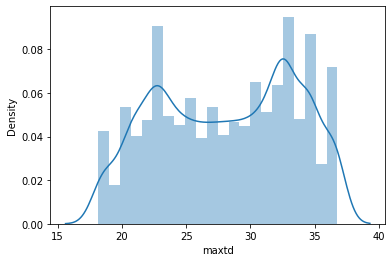

In [16]:
 sns.distplot(maxtd_flag0)

# for -60 to 60_200_2e20

In [10]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_60"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_60/CR0_60.txt']


In [11]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT200/TF3CR_60/CR0_60.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,82,23.387429,24.424508,22.388133,4.5,-13.0,1,1.912778e+22,4.945476e+20,3.135702e+18,1
1,142,22.576931,23.565819,21.633590,6.5,-13.0,1,2.121419e+22,4.945476e+20,3.477736e+18,1
2,157,22.576931,23.565819,21.633590,6.5,17.0,1,3.153416e+22,7.687444e+20,5.255693e+18,1
3,202,21.812820,22.743870,20.934628,8.5,-13.0,1,2.568975e+22,4.945476e+20,4.211434e+18,1
4,218,21.812820,22.743870,20.934628,8.5,19.0,1,1.252521e+22,2.167283e+20,2.122917e+18,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

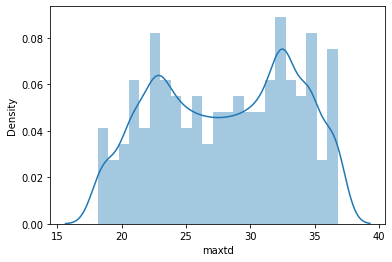

In [12]:
sns.distplot(dfCR0["maxtd"])

In [13]:
maxtd_flag1 = dfCR0[dfCR0["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR0[dfCR0["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

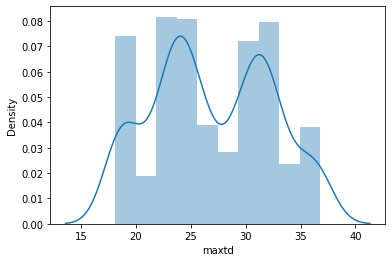

In [14]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

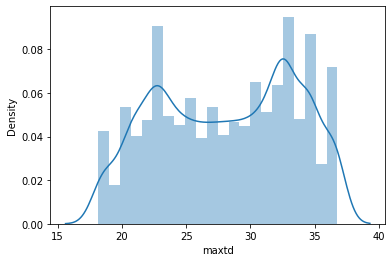

In [15]:
sns.distplot(maxtd_flag0)

# for -45 to 45_100_2e20

In [73]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR0_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR1_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR2_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR3_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR4_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR5_45.txt', '/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR6_45.txt']


In [61]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR0_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,158,22.849129,23.595892,22.148373,8.5,4.0,1,4.961004e+21,7.279071e+20,7.937606e+17,1
1,166,22.849129,23.595892,22.148373,8.5,20.0,1,1.165895e+22,1.645506e+21,1.976094e+18,1
2,201,22.282893,22.971383,21.646611,10.5,0.0,1,3.659663e+21,3.591975e+20,5.855461e+17,1
3,238,21.769824,22.392358,21.205156,12.5,-16.0,1,1.355788e+22,2.914004e+20,2.240972e+18,1
4,246,21.769824,22.392358,21.205156,12.5,0.0,1,8.703251e+21,3.591975e+20,1.392520e+18,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

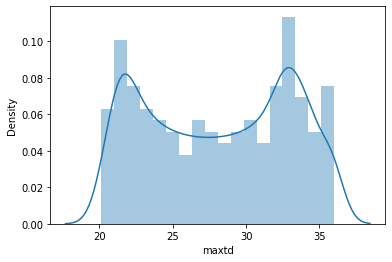

In [62]:
sns.distplot(dfCR0["maxtd"])

In [63]:
maxtd_flag1 = dfCR0[dfCR0["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR0[dfCR0["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

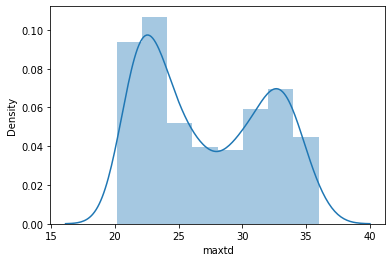

In [64]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

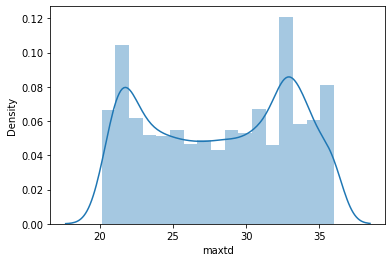

In [65]:
sns.distplot(maxtd_flag0)

In [41]:
with open(txt_files[1], "r") as f:
    print(txt_files[1])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR1=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR1.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR1_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,30,25.001329,26.162794,23.868976,2.5,18.0,1,1.941340e+21,8.995575e+20,3.235567e+17,1
1,336,19.672662,20.354480,19.072618,16.5,0.0,1,5.292832e+21,2.456765e+20,8.468532e+17,1
2,611,18.172471,18.266428,18.139737,28.5,10.0,1,2.542862e+23,2.543473e+21,4.101391e+19,1
3,612,18.172471,18.266428,18.139737,28.5,12.0,1,2.138886e+23,1.327029e+21,3.477863e+19,1
4,656,18.258754,18.471347,18.140981,30.5,10.0,1,4.871460e+22,2.543473e+21,7.857194e+18,1


In [42]:
maxtd_flag1 = dfCR1[dfCR1["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR1[dfCR1["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

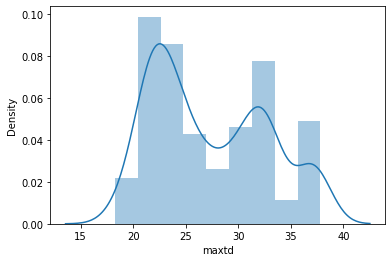

In [43]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

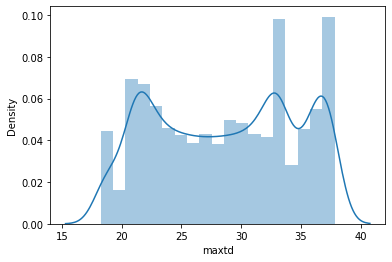

In [44]:
sns.distplot(maxtd_flag0)

In [47]:
with open(txt_files[2], "r") as f:
    print(txt_files[2])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR2=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR2.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR2_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,63,25.228635,26.393106,24.092925,4.5,-6.0,1,2.934733e+22,3.207912e+20,4.695572e+18,1
1,75,25.228635,26.393106,24.092925,4.5,18.0,1,1.084289e+23,1.990312e+21,1.807148e+19,1
2,120,24.306140,25.433502,23.216860,6.5,18.0,1,9.296265e+22,1.567628e+21,1.549377e+19,1
3,121,24.306140,25.433502,23.216860,6.5,20.0,1,1.413483e+22,1.567628e+21,2.395734e+18,1
4,193,22.586580,23.605432,21.623167,10.5,-16.0,1,1.880006e+22,2.360489e+20,3.107447e+18,1


In [48]:
maxtd_flag1 = dfCR2[dfCR2["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR2[dfCR2["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

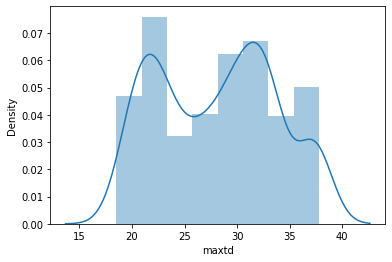

In [49]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

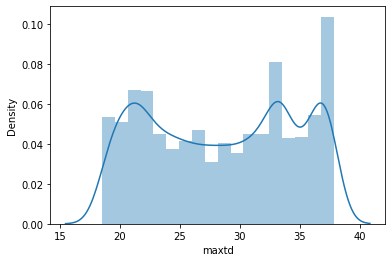

In [50]:
sns.distplot(maxtd_flag0)

In [51]:
with open(txt_files[3], "r") as f:
    print(txt_files[3])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR3=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR3.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR3_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,23,26.392532,27.487413,25.320961,2.5,4.0,1,2.096427e+22,2.329228e+21,3.354282e+18,1
1,68,25.521766,26.586402,24.489354,4.5,4.0,1,1.375221e+23,2.329228e+21,2.200353e+19,1
2,110,24.683812,25.707105,23.701307,6.5,-2.0,1,2.505195e+22,4.900132e+20,4.008312e+18,1
3,113,24.683812,25.707105,23.701307,6.5,4.0,1,1.375222e+23,2.329228e+21,2.200355e+19,1
4,158,23.887391,24.858694,22.964994,8.5,4.0,1,3.067378e+22,2.329228e+21,4.907805e+18,1


In [52]:
maxtd_flag1 = dfCR3[dfCR3["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR3[dfCR3["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

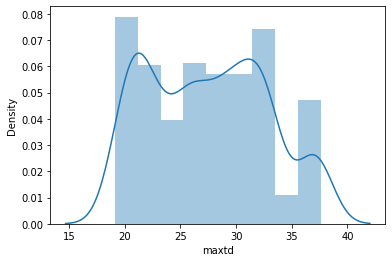

In [53]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

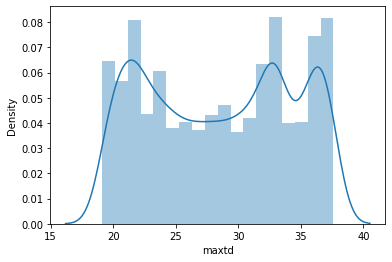

In [54]:
sns.distplot(maxtd_flag0)

In [56]:
with open(txt_files[4], "r") as f:
    print(txt_files[4])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR4=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR4.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR4_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,64,25.300040,26.398091,24.244104,4.5,-4.0,1,2.033841e+22,8.785727e+20,3.254146e+18,1
1,384,20.630840,21.167251,20.179911,18.5,6.0,1,2.225450e+22,3.269238e+20,3.560720e+18,1
2,1683,34.848687,35.372378,34.253126,76.5,-6.0,1,1.720492e+22,7.081761e+21,2.752787e+18,1
3,2393,32.129372,32.958278,31.265359,108.5,-26.0,1,1.103252e+22,3.769701e+20,1.970093e+18,1
4,2394,32.129372,32.958278,31.265359,108.5,-24.0,1,6.820841e+21,3.769701e+20,1.186233e+18,1


In [57]:
maxtd_flag1 = dfCR4[dfCR4["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR4[dfCR4["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

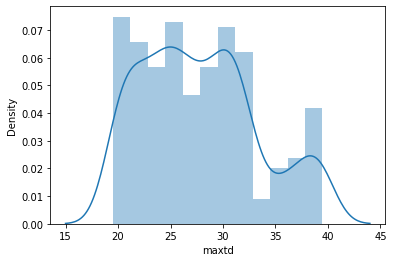

In [58]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

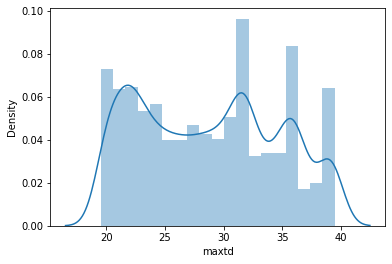

In [59]:
sns.distplot(maxtd_flag0)

In [67]:
with open(txt_files[5], "r") as f:
    print(txt_files[5])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR5=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR5.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR5_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,380,20.232712,20.732109,19.830458,18.5,-2.0,1,4.322515e+21,5.653802e+20,6.916024e+17,1
1,433,19.914524,20.292321,19.635416,20.5,14.0,1,1.271831e+22,4.787050e+21,2.084968e+18,1
2,434,19.914524,20.292321,19.635416,20.5,16.0,1,1.094881e+22,4.787050e+21,1.809721e+18,1
3,1894,35.554929,35.599249,35.439679,86.5,-34.0,1,1.492598e+21,3.866317e+20,2.870380e+17,1
4,1992,35.270928,35.504038,34.961960,90.5,-18.0,1,3.249665e+21,5.902896e+20,5.416109e+17,1


In [70]:
maxtd_flag1 = dfCR5[dfCR5["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR5[dfCR5["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

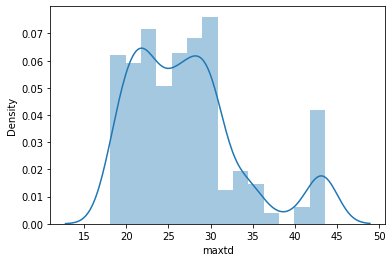

In [71]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

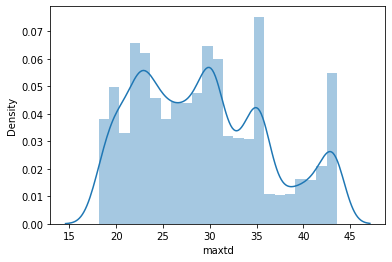

In [72]:
sns.distplot(maxtd_flag0)

In [74]:
with open(txt_files[6], "r") as f:
    print(txt_files[6])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR6=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR6.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT100/TF3CR_45/CR6_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,346,20.785147,21.513406,20.152446,16.5,20.0,1,1.734711e+22,2.373632e+20,2.940188e+18,1
1,347,20.785147,21.513406,20.152446,16.5,22.0,1,1.662192e+22,2.373632e+20,2.865849e+18,1
2,348,20.785147,21.513406,20.152446,16.5,24.0,1,1.629886e+22,2.373632e+20,2.834584e+18,1
3,1810,36.180948,36.362020,35.913117,82.5,-22.0,1,1.241968e+22,1.284446e+21,2.141325e+18,1
4,2661,27.157028,28.093048,26.242644,120.5,-30.0,1,1.827813e+21,2.378926e+20,3.384839e+17,1


In [76]:
maxtd_flag1 = dfCR6[dfCR6["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR6[dfCR6["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

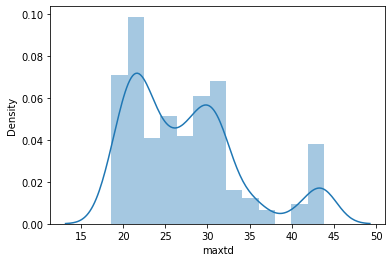

In [77]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

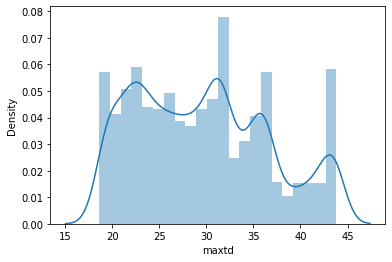

In [78]:
sns.distplot(maxtd_flag0)

check the peak are in similar position for all or not then it could be show a pattern also for every carrington rotation. they are not show any similarity.
the peaks are not depends on the phi range
it may be depends on the magnetic threshold. the number of peaks increased with increasing threshold value. It is also not conformed. what this peak density means? number of 1 is greater for that TD?peak density may be changed with CR. why? flag 1 and 0 why shows peaks in same position? for 1st two three CR TD density for 20-25 is greater in flag1 than the flag0. needs chacking for other CR  also changing the threshold.

# for -45 to 45_300_2e20

In [24]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT300/TF3CR_45"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
print(txt_files)

['/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT300/TF3CR_45/CR0_45.txt']


In [25]:
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR0.head()

/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT300/TF3CR_45/CR0_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,29,25.962236,27.175840,24.771425,2.5,16.0,1,3.292290e+22,3.803179e+20,5.441801e+18,1
1,74,24.994040,26.178072,23.841507,4.5,16.0,1,2.931836e+22,3.803179e+20,4.846010e+18,1
2,119,24.057911,25.201538,22.954114,6.5,16.0,1,8.054846e+21,3.803179e+20,1.331380e+18,1
3,248,21.524347,22.487067,20.623373,12.5,4.0,1,2.450394e+22,3.548270e+20,3.920630e+18,1
4,249,21.524347,22.487067,20.623373,12.5,6.0,1,2.454737e+22,3.548270e+20,3.927579e+18,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

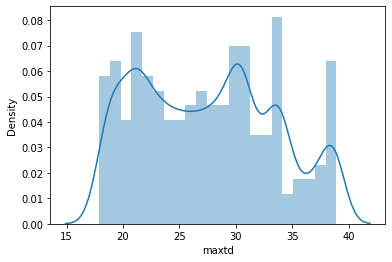

In [26]:
sns.distplot(dfCR0["maxtd"])

In [27]:
maxtd_flag1 = dfCR0[dfCR0["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR0[dfCR0["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

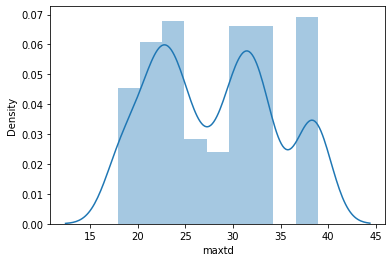

In [28]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

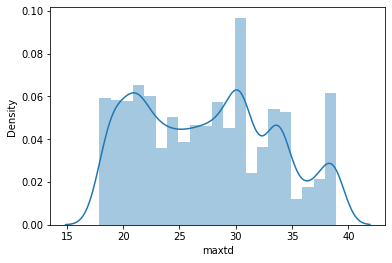

In [29]:
sns.distplot(maxtd_flag0)

# for -45 to 45_50_2e20

In [34]:
folder_path = "/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT50/TF3CR_45"
save_dir = "/home/vindia/samapti/cycle24(feb-july)/CR2149"
txt_files =sorted(glob.glob(os.path.join(folder_path, "*.txt")))
#print(txt_files)
with open(txt_files[0], "r") as f:
    print(txt_files[0])
    data = [ast.literal_eval(line.strip()) for line in f]
dfCR0=pd.DataFrame(data, columns=["patchid", "meantd", "maxtd", "mintd","lamda","phi","day","TFlux","maxTotflux","meanTotflux","flags"])
dfCR0.head()


/home/vindia/samapti/cycle24(feb-july)/CR2149/ARD/FT50/TF3CR_45/CR0_45.txt


,patchid,meantd,maxtd,mintd,lamda,phi,day,TFlux,maxTotflux,meanTotflux,flags
0,167,22.297281,22.962410,21.684507,8.5,22.0,1,1.738908e+22,4.955049e+20,2.998116e+18,1
1,168,22.297281,22.962410,21.684507,8.5,24.0,1,1.508223e+22,4.955049e+20,2.622996e+18,1
2,201,21.803420,22.402408,21.262463,10.5,0.0,1,1.404134e+22,4.499726e+20,2.246614e+18,1
3,246,21.368657,21.894483,20.905949,12.5,0.0,1,2.497949e+22,4.499726e+20,3.996719e+18,1
4,282,20.998172,21.444561,20.619338,14.5,-18.0,1,1.644717e+23,5.126820e+21,2.741195e+19,1


/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

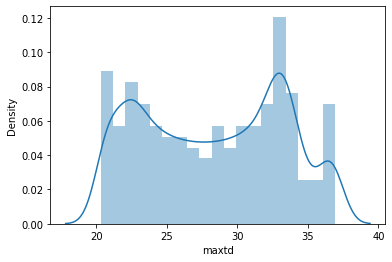

In [35]:
sns.distplot(dfCR0["maxtd"])

In [36]:
maxtd_flag1 = dfCR0[dfCR0["flags"] == 1]["maxtd"]
maxtd_flag0 = dfCR0[dfCR0["flags"] == 0]["maxtd"]

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

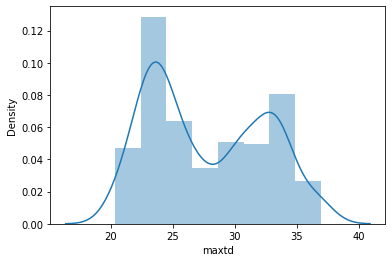

In [37]:
sns.distplot(maxtd_flag1)

/home/vindia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='maxtd', ylabel='Density'>

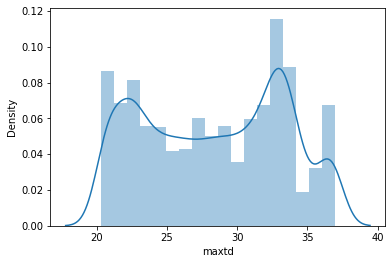

In [38]:
sns.distplot(maxtd_flag0)

# Flare

In [5]:
csv_path="/home/vindia/samapti/cycle24(feb-july)/CR2149/FD/xrt_flarecat.csv"
df = pd.read_csv(csv_path)
df.head()

,id,flarecat,start,end,peak,loc1,class,Day1,Day2,Day3,...,EIS,RHESSI,NORH,combos,movies,response,pre_flare,obs_note,region,HEK
0,0.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/20 19:17,2006/10/20 19:48,2006/10/20 19:20,S05W19,A4.3,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
1,10.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 15:13,2006/10/21 15:41,2006/10/21 15:25,S03W27,A6.4,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
2,20.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 16:18,2006/10/21 16:30,2006/10/21 16:21,S03W28,A7.1,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
3,30.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 18:03,2006/10/21 18:19,2006/10/21 18:10,S02W29,A7.1,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
4,40.0,http://xrt.cfa.harvard.edu/flare_catalog/2006_...,2006/10/21 18:24,2006/10/21 19:28,2006/10/21 18:58,S03W32,A7.8,NaN,NaN,NaN,...,0,no,,NaN,-,0.0,-,no:no_hk,NaN,http://www.lmsal.com/hek/her?cmd=view-voevent&...
